## Multilayer Perceptrons
* Binary Prediction of Poisonous Mushrooms


In [1]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = 'cuda'if torch.cuda.is_available() else 'cpu'
device

'cuda'

# step 1: data

In [3]:
!mkdir /content/data

In [4]:
!cp /content/drive/MyDrive/pytorch_learning_howsam/data/Mushroom_dataset.zip /content/data/

In [5]:
!unzip /content/data/Mushroom_dataset.zip -d /content/data

Archive:  /content/data/Mushroom_dataset.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


In [6]:
!rm /content/data/Mushroom_dataset.zip

In [7]:
df_train = pd.read_csv('/content/data/train.csv')
df_train = df_train.drop(columns=['id'])
df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [8]:
num_samples, num_faetures = df_train.shape
num_faetures -=1
num_classes =len(np.unique(df_train['class']))
num_samples, num_faetures, num_classes

(3116945, 20, 2)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB


In [10]:
df_train['class'].value_counts()

,count
class,
p,1705396
e,1411549


* split train data to valid

In [11]:
df_train, df_valid = train_test_split(df_train , test_size=0.2, random_state=42, stratify=df_train['class'])
df_train.shape , df_valid.shape, len(df_train), len(df_valid)

((2493556, 21), (623389, 21), 2493556, 623389)

## Preprocessing

In [12]:
df_train['class'].value_counts()

,count
class,
p,1364317
e,1129239


### handeling missing value (NaN)

In [13]:
df_train.isna().mean() #* 100 # sum()

,0
class,0.000000
cap-diameter,0.000002
cap-shape,0.000013
cap-surface,0.215240
cap-color,0.000004
does-bruise-or-bleed,0.000002
gill-attachment,0.168076
gill-spacing,0.403735
gill-color,0.000017
stem-height,0.000000


In [14]:
missing_threshold = 0.95
high_missing_columns = df_train.columns[df_train.isna().mean() > missing_threshold]
high_missing_columns
# drop for missing value

df_train.drop(columns=high_missing_columns, inplace=True)
df_valid.drop(columns=high_missing_columns, inplace=True)
df_train.shape, df_valid.shape

((2493556, 21), (623389, 21))

## NaN (missing value)
* columns Numerical (Median)
* columns Categorical (Mod)







In [15]:
mode_values = df_train.mode()
mode_values = mode_values.loc[0].to_dict()
mode_values['cap-diameter']

1.49

In [16]:
# for Median
median_values = df_train.median(numeric_only=True).to_dict()
median_values

{'cap-diameter': 5.75, 'stem-height': 5.88, 'stem-width': 9.65}

In [17]:
# this section replace mode and median for columns
for column in df_train.columns:
  #print(column)
  if df_train[column].isna().any():

    if df_train[column].dtype == 'object':
      df_train[column] = df_train[column].fillna(mode_values[column])
      df_valid[column] = df_valid[column].fillna(mode_values[column])

    else:
      df_train[column] = df_train[column].fillna(median_values[column])
      df_valid[column] = df_valid[column].fillna(median_values[column])

df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
586767,p,4.95,x,t,p,f,a,c,w,3.80,...,b,s,y,u,w,f,f,k,d,a
2665706,p,1.47,b,y,n,f,a,c,k,5.23,...,b,s,w,u,w,f,f,k,d,u
1270574,e,10.29,x,e,l,f,x,c,w,7.17,...,b,s,w,u,w,f,f,k,d,a
2935630,p,7.45,s,d,n,t,d,c,n,6.20,...,b,s,e,u,w,f,f,k,d,a
3113991,p,5.44,x,t,e,f,a,c,r,3.23,...,b,s,y,u,w,f,f,k,d,a


In [18]:
# check missing value
df_train.isna().sum()

,0
class,0
cap-diameter,0
cap-shape,0
cap-surface,0
cap-color,0
does-bruise-or-bleed,0
gill-attachment,0
gill-spacing,0
gill-color,0
stem-height,0


## Encoding
* convert column categorical to Numerical

In [19]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ordinal_encoder

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [20]:
# convert
cat_cols_train = df_train.select_dtypes(include=['object']).columns
cat_cols_train

Index(['class', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')

In [21]:
# replace
df_train[cat_cols_train] = ordinal_encoder.fit_transform(df_train[cat_cols_train].astype(str))
df_valid[cat_cols_train] = ordinal_encoder.transform(df_valid[cat_cols_train].astype(str))
df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
586767,1.0,4.95,61.0,69.0,61.0,8.0,36.0,22.0,53.0,3.80,...,13.0,43.0,47.0,17.0,21.0,4.0,14.0,15.0,20.0,0.0
2665706,1.0,1.47,39.0,74.0,59.0,8.0,36.0,22.0,37.0,5.23,...,13.0,43.0,45.0,17.0,21.0,4.0,14.0,15.0,20.0,2.0
1270574,0.0,10.29,61.0,46.0,57.0,8.0,64.0,22.0,53.0,7.17,...,13.0,43.0,45.0,17.0,21.0,4.0,14.0,15.0,20.0,0.0
2935630,1.0,7.45,57.0,40.0,59.0,19.0,39.0,22.0,40.0,6.20,...,13.0,43.0,25.0,17.0,21.0,4.0,14.0,15.0,20.0,0.0
3113991,1.0,5.44,61.0,69.0,51.0,8.0,36.0,22.0,43.0,3.23,...,13.0,43.0,47.0,17.0,21.0,4.0,14.0,15.0,20.0,0.0


In [22]:
df_train['class'].value_counts()

,count
class,
1.0,1364317
0.0,1129239


## Normalization ?

## ibalanced ?

In [23]:
df_train['class'].value_counts()

,count
class,
1.0,1364317
0.0,1129239


*  preper  data

In [24]:
df_train.shape

(2493556, 21)

In [25]:
x_train = df_train.drop(['class'], axis=1).values
y_train = df_train['class'].values.reshape(-1,1)

x_valid = df_valid.drop(['class'], axis=1).values
y_valid = df_valid['class'].values.reshape(-1,1)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((2493556, 20), (2493556, 1), (623389, 20), (623389, 1))

In [26]:
# tensor
x_train = torch.as_tensor(x_train, dtype=torch.float)
y_train = torch.as_tensor(y_train, dtype=torch.float)

x_valid = torch.as_tensor(x_valid, dtype=torch.float )
y_valid = torch.as_tensor(y_valid, dtype=torch.float)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([2493556, 20]),
 torch.Size([2493556, 1]),
 torch.Size([623389, 20]),
 torch.Size([623389, 1]))

In [27]:
train_set = TensorDataset(x_train, y_train)
valid_set = TensorDataset(x_valid, y_valid)

train_loader = DataLoader(dataset=train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=256)

In [28]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape , type(x_batch)

(torch.Size([256, 20]), torch.Size([256, 1]), torch.Tensor)

# model

In [29]:
nf1 = 4 * num_faetures
model = nn.Sequential(
    nn.Linear(in_features=num_faetures, out_features= nf1 ),
    nn.ReLU(),
    nn.Linear(in_features=nf1, out_features=num_classes - 1),
    nn.Sigmoid()

)
model[0].weight.shape, model[0].bias.shape
model.to(device)

Sequential(
  (0): Linear(in_features=20, out_features=80, bias=True)
  (1): ReLU()
  (2): Linear(in_features=80, out_features=1, bias=True)
  (3): Sigmoid()
)

# loss

In [30]:
loss_fn = nn.BCELoss()
loss_fn

BCELoss()

In [31]:
# test loss
y_hat = model(x_batch.to(device))
loss =loss_fn(y_hat, y_batch.to(device))
y_hat.shape, loss

(torch.Size([256, 1]),
 tensor(5.8963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>))

# optimizer

In [32]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

# train

In [33]:
num_epochs = 10
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []
best_loss_valid =10000

In [77]:

for epoch in range(num_epochs):

  mean_loss_train, mean_loss_valid = 0, 0
  mean_acc_train, mean_acc_valid = 0, 0

  for x_batch, y_batch in train_loader:

    # cuda
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    # model
    y_hat = model(x_batch)

    # loss
    loss = loss_fn(y_hat, y_batch)

    # gradient
    loss.backward()

    # update
    optimizer.step()
    optimizer.zero_grad()


    mean_loss_train += loss.item() * len(x_batch)
    mean_acc_train +=(y_hat.round()==y_batch).sum().item()

  mean_loss_train = mean_loss_train / len(train_set)
  mean_acc_train = mean_acc_train  / len(train_set)
  loss_train_hist.append(mean_loss_train)
  acc_train_hist.append(mean_acc_train)


  with torch.no_grad():
    for x_batch, y_batch in valid_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_hat = model(x_batch)
      loss = loss_fn(y_hat, y_batch)
      mean_loss_valid += loss.item()* len(x_batch)
      mean_acc_valid +=(y_hat.round()==y_batch).sum().item()

    mean_loss_valid = mean_loss_valid / len(valid_set)
    mean_acc_valid = mean_acc_valid  / len(valid_set)
    loss_valid_hist.append(mean_loss_valid)
    acc_valid_hist.append(mean_acc_valid)

  print(
      f" Epoch: {epoch} "
      f" Loss train: {mean_loss_train:.2f}"
      f" Accuracy train: {mean_acc_train:.2f}"
      f" Loss valid: {mean_loss_valid:.2f}"
      f" Accuracy valid: {mean_acc_valid:.2f}"
      )

  if mean_loss_valid < best_loss_valid:
    torch.save(model, 'best-model_gpu1.pt')
    best_loss_valid = mean_loss_valid
    print('save model!')
    print()


 Epoch: 0  Loss train: 0.19 Accuracy train: 0.94 Loss valid: 0.18 Accuracy valid: 0.95
save model!

 Epoch: 1  Loss train: 0.18 Accuracy train: 0.95 Loss valid: 0.18 Accuracy valid: 0.95
save model!

 Epoch: 2  Loss train: 0.17 Accuracy train: 0.95 Loss valid: 0.17 Accuracy valid: 0.95
save model!

 Epoch: 3  Loss train: 0.17 Accuracy train: 0.95 Loss valid: 0.16 Accuracy valid: 0.96
save model!

 Epoch: 4  Loss train: 0.17 Accuracy train: 0.95 Loss valid: 0.20 Accuracy valid: 0.94
 Epoch: 5  Loss train: 0.16 Accuracy train: 0.95 Loss valid: 0.19 Accuracy valid: 0.94
 Epoch: 6  Loss train: 0.16 Accuracy train: 0.96 Loss valid: 0.15 Accuracy valid: 0.96
save model!

 Epoch: 7  Loss train: 0.15 Accuracy train: 0.96 Loss valid: 0.15 Accuracy valid: 0.96
save model!

 Epoch: 8  Loss train: 0.15 Accuracy train: 0.96 Loss valid: 0.14 Accuracy valid: 0.96
save model!

 Epoch: 9  Loss train: 0.15 Accuracy train: 0.96 Loss valid: 0.14 Accuracy valid: 0.96
save model!



In [78]:
len(loss_train_hist)

20

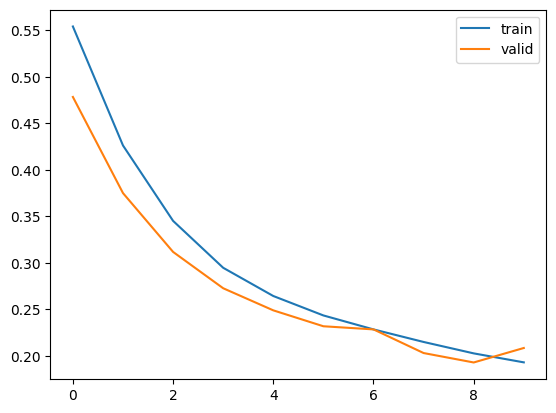

In [80]:
plt.plot(torch.arange(num_epochs), loss_train_hist[:num_epochs])
plt.plot(torch.arange(num_epochs), loss_valid_hist[:num_epochs])
plt.legend(['train', 'valid']);

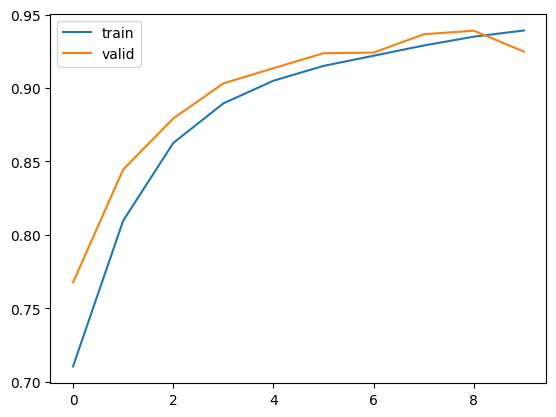

In [81]:
plt.plot(torch.arange(num_epochs), acc_train_hist[:num_epochs])
plt.plot(torch.arange(num_epochs), acc_valid_hist[:num_epochs])
plt.legend(['train', 'valid' ]);

# test

In [82]:
df_test = pd.read_csv('/content/data/test.csv')

df_test.shape

(2077964, 21)

In [39]:
df_test.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [40]:
df_test


,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,5194904,0.88,x,g,w,f,a,d,w,2.67,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
2077960,5194905,3.12,x,s,w,f,d,c,w,2.69,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
2077961,5194906,5.73,x,e,e,f,a,NaN,w,6.16,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
2077962,5194907,5.03,b,g,n,f,a,d,g,6.00,...,NaN,s,g,NaN,NaN,f,f,NaN,d,a


In [41]:
df_test.drop(['id'], axis=1, inplace=True)

In [42]:
df_test.shape

(2077964, 20)

In [43]:
# missing value
df_test.isna().mean() * 100

,0
cap-diameter,0.000337
cap-shape,0.001492
cap-surface,21.506821
cap-color,0.000626
does-bruise-or-bleed,0.000481
gill-attachment,16.834796
gill-spacing,40.404694
gill-color,0.002358
stem-height,0.000048
stem-width,0.000000


In [44]:
# mode for Categorics columns
mode_values_test = df_test.mode()
mode_values_test = mode_values_test.loc[0].to_dict()
mode_values_test

{'cap-diameter': 1.49,
 'cap-shape': 'x',
 'cap-surface': 't',
 'cap-color': 'n',
 'does-bruise-or-bleed': 'f',
 'gill-attachment': 'a',
 'gill-spacing': 'c',
 'gill-color': 'w',
 'stem-height': 5.24,
 'stem-width': 2.41,
 'stem-root': 'b',
 'stem-surface': 's',
 'stem-color': 'w',
 'veil-type': 'u',
 'veil-color': 'w',
 'has-ring': 'f',
 'ring-type': 'f',
 'spore-print-color': 'k',
 'habitat': 'd',
 'season': 'a'}

In [45]:
# Numerical columns median
median_values_test = df_test.median(numeric_only=True).to_dict()
median_values_test

{'cap-diameter': 5.74, 'stem-height': 5.88, 'stem-width': 9.64}

In [46]:
for column in df_test.columns:
  #print(column)
  if df_test[column].isna().any():

    if df_test[column].dtype == 'object':
      df_test[column] = df_test[column].fillna(mode_values_test[column])

    else:
      df_test[column] = df_test[column].fillna(median_values_test[column])


df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,x,t,n,t,a,c,w,11.13,17.12,b,s,w,u,w,t,g,k,d,a
1,6.90,o,t,o,f,a,c,y,1.27,10.75,b,s,n,u,w,f,f,k,d,a
2,2.00,b,g,n,f,a,c,n,6.18,3.14,b,s,n,u,w,f,f,k,d,s
3,3.47,x,t,n,f,s,c,n,4.98,8.51,b,s,w,u,n,t,z,k,d,u
4,6.17,x,h,y,f,p,c,y,6.73,13.70,b,s,y,u,y,t,f,k,d,u


In [47]:
df_test.isna().sum()

,0
cap-diameter,0
cap-shape,0
cap-surface,0
cap-color,0
does-bruise-or-bleed,0
gill-attachment,0
gill-spacing,0
gill-color,0
stem-height,0
stem-width,0


##Encoding

In [48]:
# ordinal_encoder_test = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# ordinal_encoder_test

In [49]:
cat_cols_test = df_test.select_dtypes(include=['object']).columns
cat_cols_test

Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')

In [50]:
ordinal_encoder = OrdinalEncoder()

# Fit the encoder on the training data
ordinal_encoder.fit(df_test[cat_cols_test])  # Where X_train is your training DataFrame

# Transform the testing data
df_test[cat_cols_test] = ordinal_encoder.transform(df_test[cat_cols_test].astype(str))

In [51]:
df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,59.0,53.0,44.0,18.0,37.0,17.0,52.0,11.13,17.12,9.0,45.0,51.0,12.0,21.0,17.0,15.0,18.0,16.0,0.0
1,6.90,50.0,53.0,45.0,5.0,37.0,17.0,54.0,1.27,10.75,9.0,45.0,38.0,12.0,21.0,6.0,14.0,18.0,16.0,0.0
2,2.00,36.0,38.0,44.0,5.0,37.0,17.0,41.0,6.18,3.14,9.0,45.0,38.0,12.0,21.0,6.0,14.0,18.0,16.0,1.0
3,3.47,59.0,53.0,44.0,5.0,57.0,17.0,41.0,4.98,8.51,9.0,45.0,51.0,12.0,14.0,17.0,35.0,18.0,16.0,2.0
4,6.17,59.0,39.0,55.0,5.0,55.0,17.0,54.0,6.73,13.70,9.0,45.0,53.0,12.0,22.0,17.0,14.0,18.0,16.0,2.0


In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   cap-diameter          float64
 1   cap-shape             float64
 2   cap-surface           float64
 3   cap-color             float64
 4   does-bruise-or-bleed  float64
 5   gill-attachment       float64
 6   gill-spacing          float64
 7   gill-color            float64
 8   stem-height           float64
 9   stem-width            float64
 10  stem-root             float64
 11  stem-surface          float64
 12  stem-color            float64
 13  veil-type             float64
 14  veil-color            float64
 15  has-ring              float64
 16  ring-type             float64
 17  spore-print-color     float64
 18  habitat               float64
 19  season                float64
dtypes: float64(20)
memory usage: 317.1 MB


In [53]:
df_test

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,59.0,53.0,44.0,18.0,37.0,17.0,52.0,11.13,17.12,9.0,45.0,51.0,12.0,21.0,17.0,15.0,18.0,16.0,0.0
1,6.90,50.0,53.0,45.0,5.0,37.0,17.0,54.0,1.27,10.75,9.0,45.0,38.0,12.0,21.0,6.0,14.0,18.0,16.0,0.0
2,2.00,36.0,38.0,44.0,5.0,37.0,17.0,41.0,6.18,3.14,9.0,45.0,38.0,12.0,21.0,6.0,14.0,18.0,16.0,1.0
3,3.47,59.0,53.0,44.0,5.0,57.0,17.0,41.0,4.98,8.51,9.0,45.0,51.0,12.0,14.0,17.0,35.0,18.0,16.0,2.0
4,6.17,59.0,39.0,55.0,5.0,55.0,17.0,54.0,6.73,13.70,9.0,45.0,53.0,12.0,22.0,17.0,14.0,18.0,16.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,0.88,59.0,38.0,53.0,5.0,37.0,18.0,52.0,2.67,1.35,9.0,45.0,29.0,12.0,21.0,6.0,14.0,18.0,16.0,2.0
2077960,3.12,59.0,50.0,53.0,5.0,41.0,17.0,52.0,2.69,7.38,9.0,45.0,51.0,12.0,21.0,6.0,14.0,18.0,19.0,0.0
2077961,5.73,59.0,36.0,34.0,5.0,37.0,17.0,52.0,6.16,9.74,9.0,45.0,53.0,12.0,21.0,17.0,35.0,18.0,16.0,0.0
2077962,5.03,36.0,38.0,44.0,5.0,37.0,18.0,31.0,6.00,3.46,9.0,45.0,31.0,12.0,21.0,6.0,14.0,18.0,16.0,0.0


In [54]:
# print(df_test[cat_cols_test].head())

In [55]:
# df_test[cat_cols_test] = ordinal_encoder_test.transform(df_test[cat_cols_test].astype(str))
# df_test.head()

In [56]:
df_test_ = df_test.values
df_test.shape

(2077964, 20)

In [57]:
df_test_ = torch.as_tensor(df_test_, dtype=torch.float)
df_test.shape

(2077964, 20)

In [58]:
y_test = torch.zeros((df_test_.shape[0], 1),dtype=torch.float)
y_test.shape

torch.Size([2077964, 1])

In [59]:
test_set = TensorDataset(df_test_, y_test)
test_loader = DataLoader(dataset=test_set, batch_size=256)
test_set.tensors

(tensor([[ 8.6400, 59.0000, 53.0000,  ..., 18.0000, 16.0000,  0.0000],
         [ 6.9000, 50.0000, 53.0000,  ..., 18.0000, 16.0000,  0.0000],
         [ 2.0000, 36.0000, 38.0000,  ..., 18.0000, 16.0000,  1.0000],
         ...,
         [ 5.7300, 59.0000, 36.0000,  ..., 18.0000, 16.0000,  0.0000],
         [ 5.0300, 36.0000, 38.0000,  ..., 18.0000, 16.0000,  0.0000],
         [15.5100, 41.0000, 53.0000,  ..., 18.0000, 16.0000,  3.0000]]),
 tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]))

In [60]:
test_loader.batch_size

256

In [61]:
x_batch, y_batch = next(iter(test_loader))


#x_batch = torch.as_tensor(x_batch)

In [62]:
x_batch.shape

torch.Size([256, 20])

In [63]:
y_hat = model(x_batch.to(device))
y_hat.shape

torch.Size([256, 1])

In [64]:
y_hat_round = y_hat.round()
y_hat_round.shape

torch.Size([256, 1])

In [65]:
class_dict = {0.:'e',
              1.:'p'}
class_dict

{0.0: 'e', 1.0: 'p'}

In [66]:
y_ = y_hat_round.squeeze()

y_

tensor([1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 

In [67]:
# result_string = []
# for i in range(len(y_)):
#     # Assuming class_dict[0] and class_dict[1] should be integers
#     if y_[i].item() == 0.:
#         result_string.append(class_dict[0]) # Convert to float if necessary
#     else:
#         result_string.append(class_dict[1])

# print(result_string)
# print(len(result_string))         # Convert to float if necessary

In [68]:
y_[2].item()

1.0

In [83]:
result_string = []
with torch.no_grad():
  for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    y_hat = model(x_batch)
    # claculate accuracy
    y_hat_round = y_hat.round()
    y_low_dim = y_hat_round.squeeze()
    for i in range(len(y_low_dim)):
        # Assuming class_dict[0] and class_dict[1] should be integers
        if y_low_dim[i].item() == 0.:
            result_string.append(class_dict[0]) # Convert to float if necessary
        else:
            result_string.append(class_dict[1])

  print(result_string[:10])
  print(len(result_string))




['p', 'p', 'p', 'p', 'p', 'p', 'e', 'e', 'p', 'p']
2077964


In [84]:
new_data = pd.DataFrame(result_string, columns=['class'])

In [85]:
new_data.head()

,class
0,p
1,p
2,p
3,p
4,p


In [86]:
new_data.shape

(2077964, 1)

In [87]:
new_data.tail()

,class
2077959,p
2077960,p
2077961,p
2077962,p
2077963,p


In [88]:
new_data['class'].value_counts()

,count
class,
p,1728512
e,349452


In [90]:
new_data['class'].values

array(['p', 'p', 'p', ..., 'p', 'p', 'p'], dtype=object)

In [91]:
new_data.to_csv('/content/drive/MyDrive/new_submission.csv', index=True)